# Beta Neutral Portfolio

Diego Alvarez <br> diego.alvarez@colorado.edu

# Background

In this case we are going to build some example beta neutral portfolios. Both will use the OLS methodology for finding beta and alpha, although one will use the Gerber calculation and the other will use the standard covariance calculation. 

# Packages

In [92]:
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

Acesss Gerber Object

In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))
from Gerber import Gerber

# Beta Neutral Sector Excess Return

## Collect Data

In [3]:
end_date = dt.date.today()
start_date = dt.date(year = end_date.year - 30, month = 1, day = 1)
urls = ["https://etfdb.com/etfs/issuers/state-street/#etfs&sort_name=assets_under_management&sort_order=desc&page={}".format(i + 1) for i in range(6)]

In [4]:
df_tickers_raw = pd.DataFrame()
for url in urls:
    
    df_tmp = pd.read_html(url)[0]
    df_tickers_raw = pd.concat([df_tickers_raw, df_tmp])

In [15]:
df_tickers = (df_tickers_raw[
    df_tickers_raw.columns[0:3]].
    rename(columns = {
        "Symbol Symbol": "symbol",
        "ETF Name ETF Name": "name",
        "Asset Class Asset Class": "asset"}).
    assign(
        sector_name = lambda x: x.symbol.str[0],
        sector = lambda x: x.name.str.split("Select").str[0]).
    query("sector_name == 'X' & asset == 'Equity'")
    [["symbol", "sector"]].
    drop_duplicates())

In [30]:
import os
import requests
import pandas as pd
import datetime as dt

from bs4 import BeautifulSoup

url = "https://stockanalysis.com/etf/provider/state-street/"
headers = headers = {"User-Agent": "Chrome/92.0.4515.131 Safari/537.36"}
response = requests.get(url = url, headers = headers)
soup = BeautifulSoup(response.text, "html.parser")

In [40]:
tickers_raw = [article.text for article in soup.find_all(class_ = "sym svelte-dlknfz")]
names_raw = [article.text for article in soup.find_all(class_ = "slw svelte-dlknfz")]

In [65]:
df_tickers = (pd.DataFrame({
    tickers_raw[0].strip(): tickers_raw[1:],
    names_raw[0].strip(): names_raw[1:]}).
    rename(columns = {"Fund Name": "Fund"}).
    assign(name = lambda x: x.Symbol.str[0]).
    query("name == 'X'").
    drop(columns = ["name"]))

tickers = df_tickers.Symbol.to_list() + ["SPY"]

In [68]:
end_date = dt.date.today()
start_date = dt.date(year = end_date.year - 30, month = 1, day = 1)
df_raw = yf.download(tickers = tickers, start = start_date, end = end_date)

[*********************100%***********************]  30 of 30 completed


In [76]:
df_prep = (df_raw[
    "Adj Close"].
    pct_change().
    reset_index().
    melt(id_vars = ["Date", "SPY"], value_name = "sector_rtn", var_name = ["ETF"]).
    dropna().
    query("sector_rtn != 0"))

## Data Stats

In [81]:
(df_prep.drop(
    columns = ["SPY", "sector_rtn"]).
    groupby("ETF").
    agg(["min", "max", "count"])
    ["Date"].
    sort_values("count"))

,min,max,count
ETF,,,
XLSR,2019-04-04,2024-01-12,1196
XLC,2018-06-20,2024-01-12,1391
XWEB,2016-06-29,2024-01-02,1680
XITK,2016-01-15,2024-01-12,1953
XLRE,2015-10-09,2024-01-12,2049
XAR,2011-09-30,2024-01-12,2955
XSW,2011-10-04,2024-01-12,2987
XHS,2011-09-30,2024-01-12,3006
XTL,2011-01-31,2024-01-12,3106


In [134]:
def _rollingOLS(
    df: pd.DataFrame,
    window: float = 60):
    
    etf = df.ETF.iloc[0]
    print("Working on", etf)
    
    df_tmp = df.sort_index()
    endog, exog = df_tmp.sector_rtn, df_tmp.SPY
    
    df_ols = (RollingOLS(
        endog = endog, exog = sm.add_constant(exog), window = window).
        fit())
    
    df_ols_params = (df_ols.params.rename(
        columns = {
            "const": "alpha",
            "SPY": "beta"}).
        assign(
            date = lambda x: df_tmp.index,
            regression = "OLS").
        dropna().
        reset_index(drop = True))
    
    df_gerber_params = (Gerber().RollingGerberOLS(
        endog = endog, exog = exog, window = window).
        assign(
            regression = "Gerber").
        dropna())
    
    df_out = pd.concat([df_ols_params, df_gerber_params])
    
    return df_out

In [147]:
try: 
    df_regressions = pd.read_parquet(path = "regressions.parquet", engine = "pyarrow")
    
except: 
    
    df_regressions = df_prep.set_index("Date").groupby("ETF").apply(_rollingOLS).reset_index().drop(columns = ["level_1"])
    df_regressions.reset_index().drop(columns = ["level_1"]).to_parquet(path = "regressions.parquet", engine = "pyarrow")

In [195]:
df_alpha = df_regressions[["ETF", "alpha", "date", "regression"]].pivot(index = "date", columns = ["ETF", "regression"], values = "alpha").reset_index().melt(id_vars = "date").dropna()
df_beta = df_regressions[["ETF", "beta", "date", "regression"]].pivot(index = "date", columns = ["ETF", "regression"], values = "beta").reset_index().melt(id_vars = "date").dropna()

In [227]:
def make_line_graph(df: pd.DataFrame, name: str):

    ETFs = df.ETF.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = 5, nrows = 6, figsize = (30,15))

    i, j = 0,0
    for etf in ETFs:

        df_tmp = (df.query(
            "ETF == @etf").
            drop(columns = ["ETF"]).
            pivot(index = "date", columns = "regression", values = "value"))

        df_tmp.plot(
            ax = axes[i,j],
            legend = False,
            ylabel = name,
            title = etf,
            sharex = True)

        j += 1
        if j == 5: 
            i += 1
            j = 0

    plt.tight_layout(pad = 3.5)
    fig.suptitle("60d Rolling {} from {} to {} Blue: OLS Orange: Gerber".format(
        name,
        df_alpha.date.min().date(),
        df_alpha.date.max().date()))
    
    plt.show()

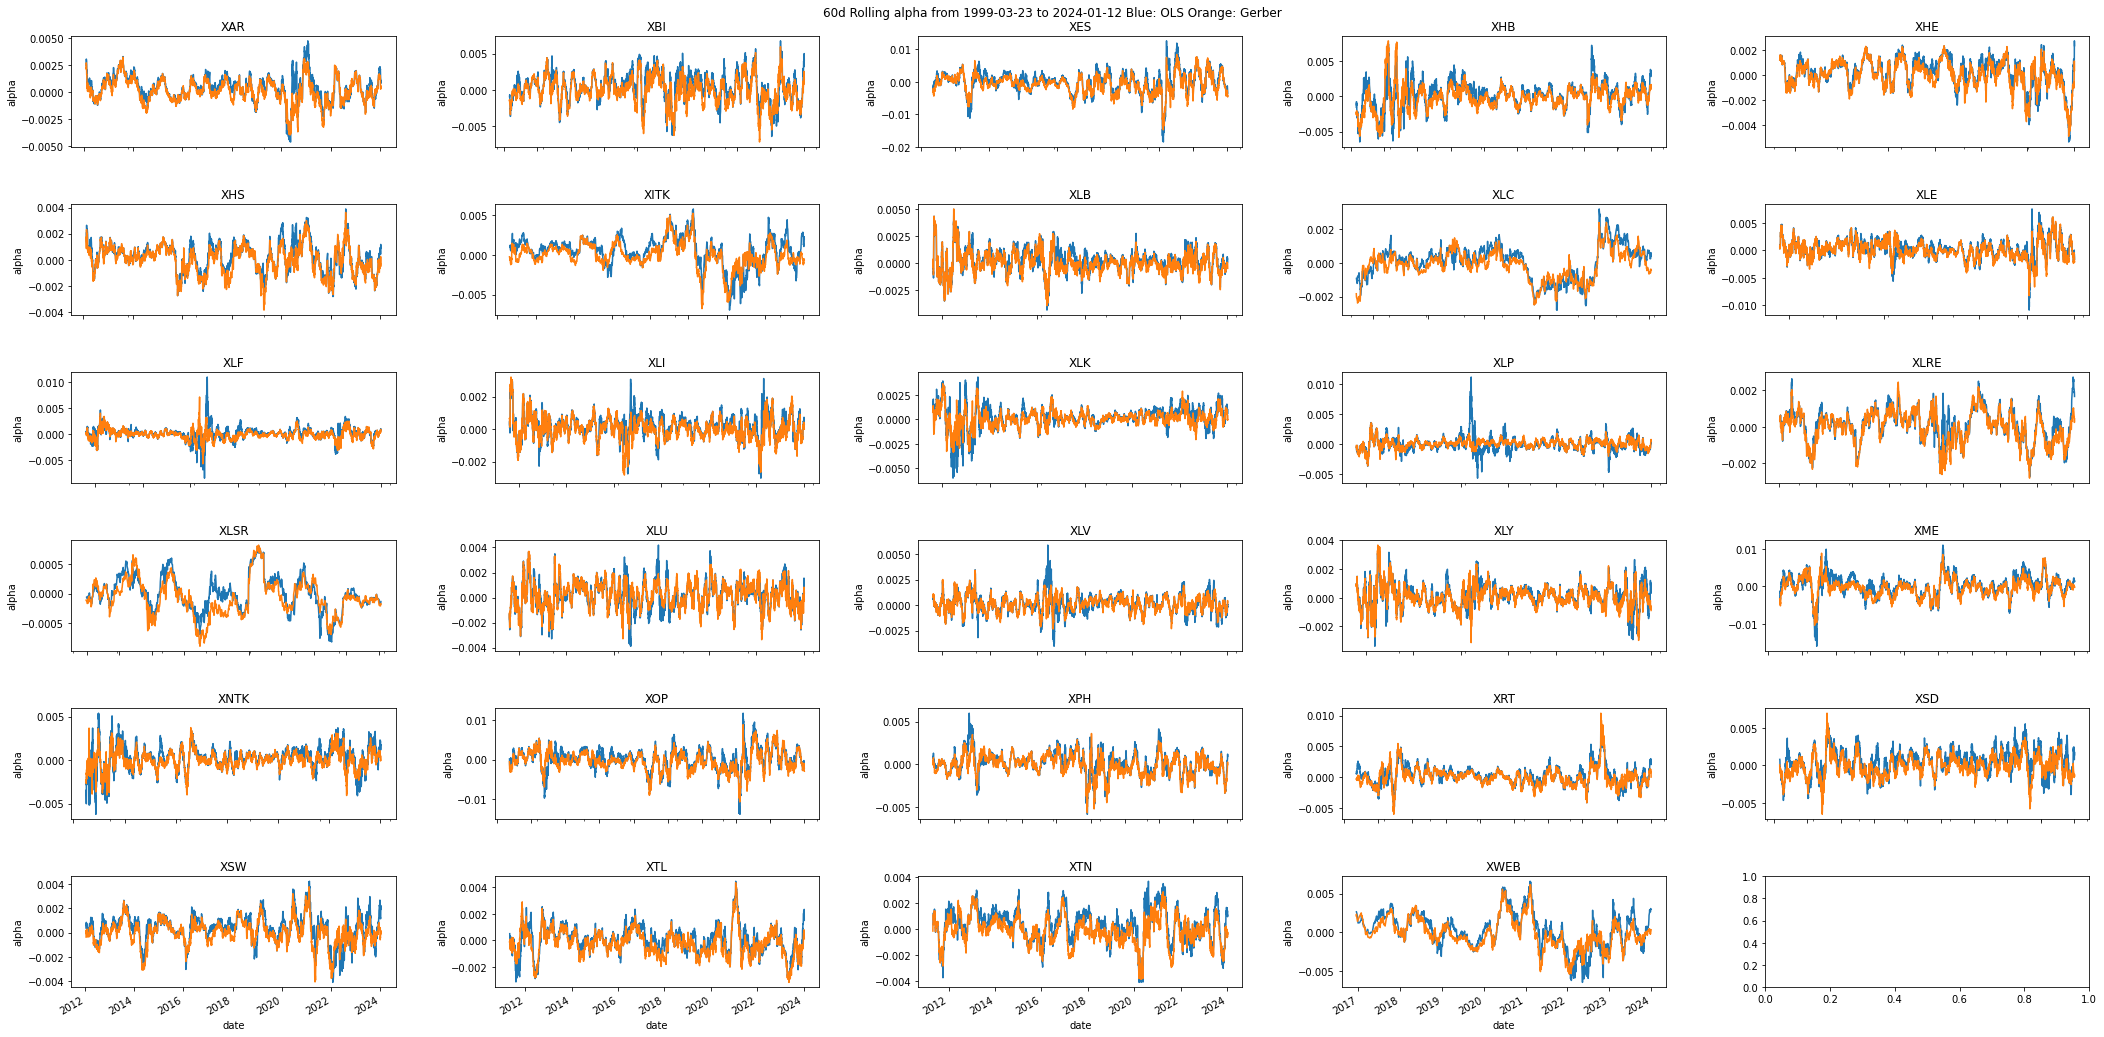

In [228]:
make_line_graph(df_alpha, "alpha")

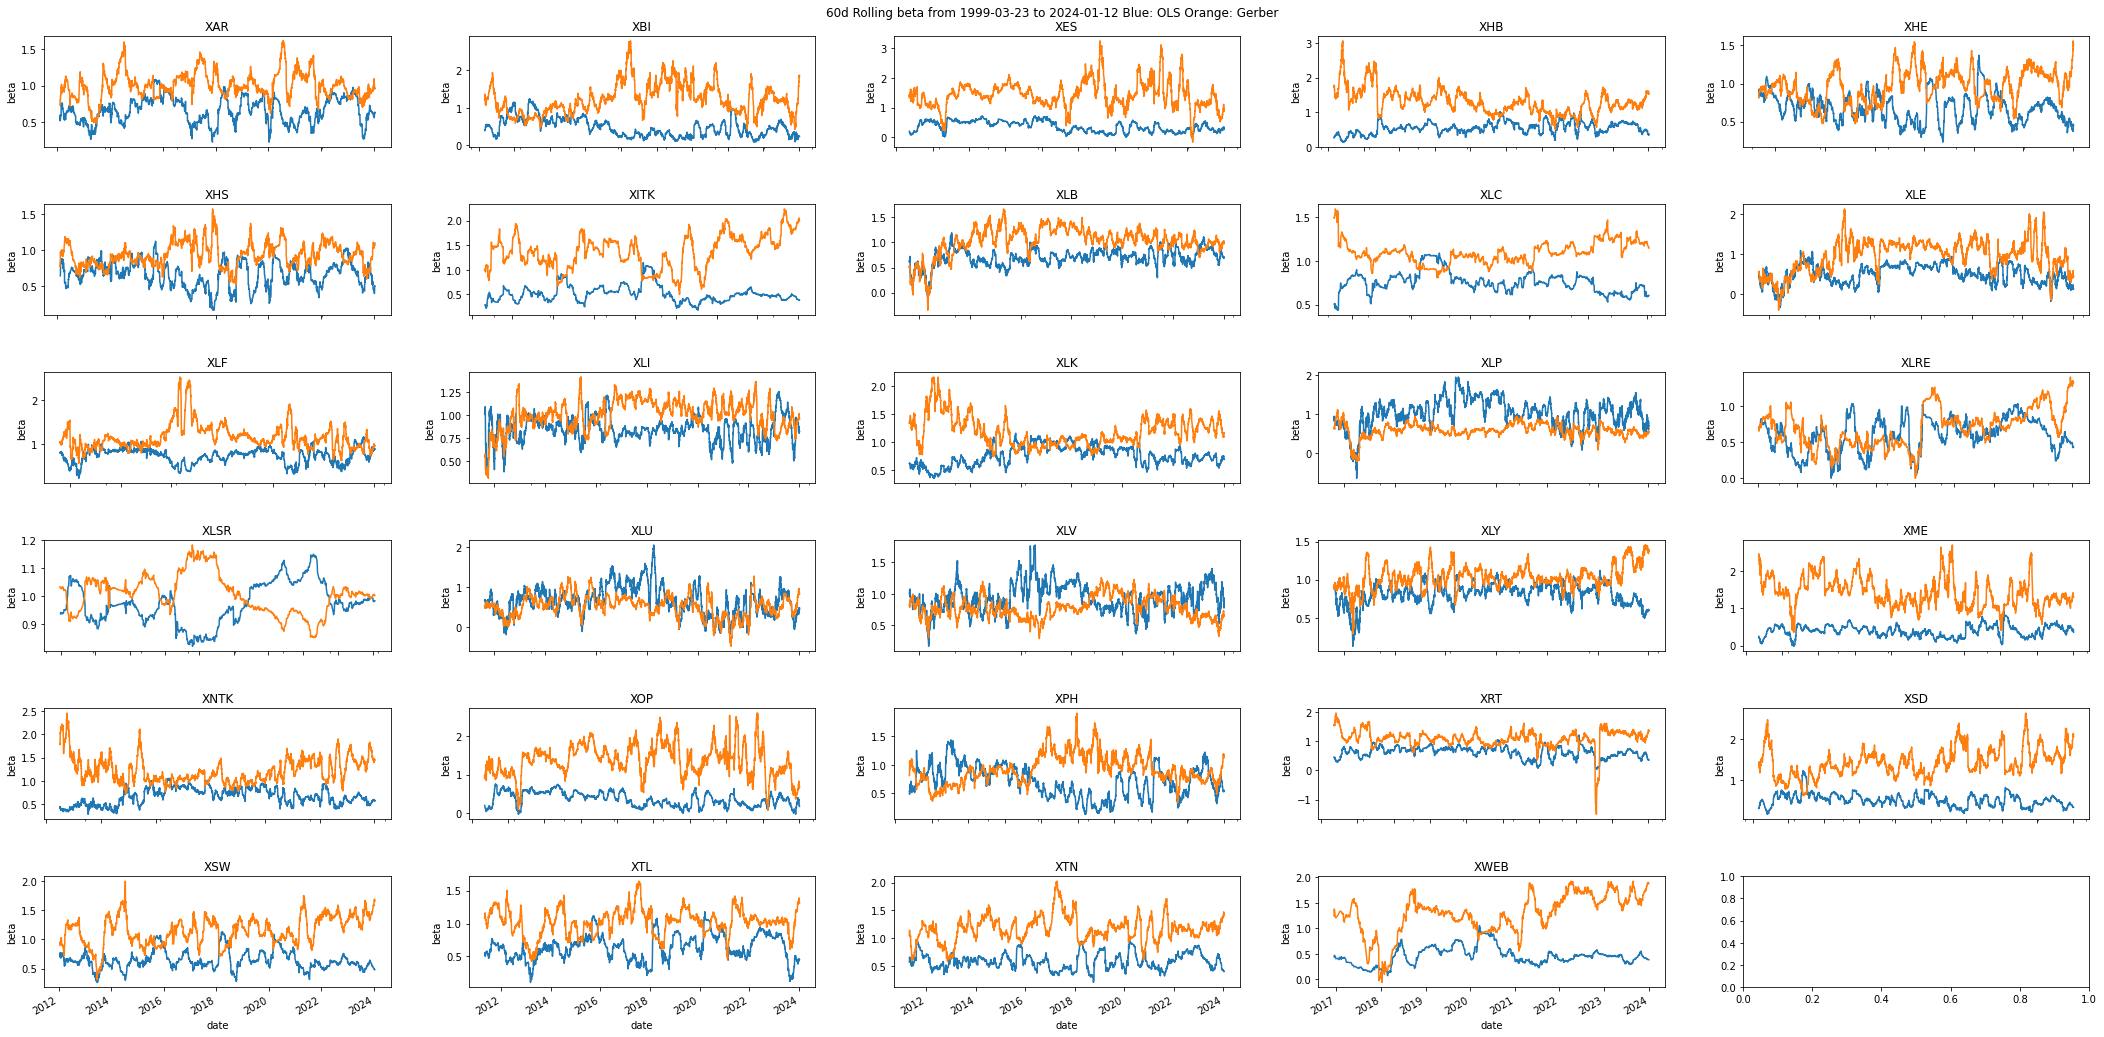

In [229]:
make_line_graph(df_beta, "beta")

In [232]:
def make_hist_graph(df: pd.DataFrame, name: str):

    ETFs = df.ETF.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = 5, nrows = 6, figsize = (30,15))

    i, j = 0,0
    for etf in ETFs:

        df_tmp = (df.query(
            "ETF == @etf").
            drop(columns = ["ETF"]).
            pivot(index = "date", columns = "regression", values = "value"))

        df_tmp.plot(
            ax = axes[i,j],
            kind = "hist",
            legend = False,
            ylabel = name,
            title = etf,
            bins = 30,
            alpha = 0.6,
            sharex = True)

        j += 1
        if j == 5: 
            i += 1
            j = 0

    plt.tight_layout(pad = 3.5)
    fig.suptitle("60d Rolling {} from {} to {} Blue: OLS Orange: Gerber".format(
        name,
        df_alpha.date.min().date(),
        df_alpha.date.max().date()))
    
    plt.show()

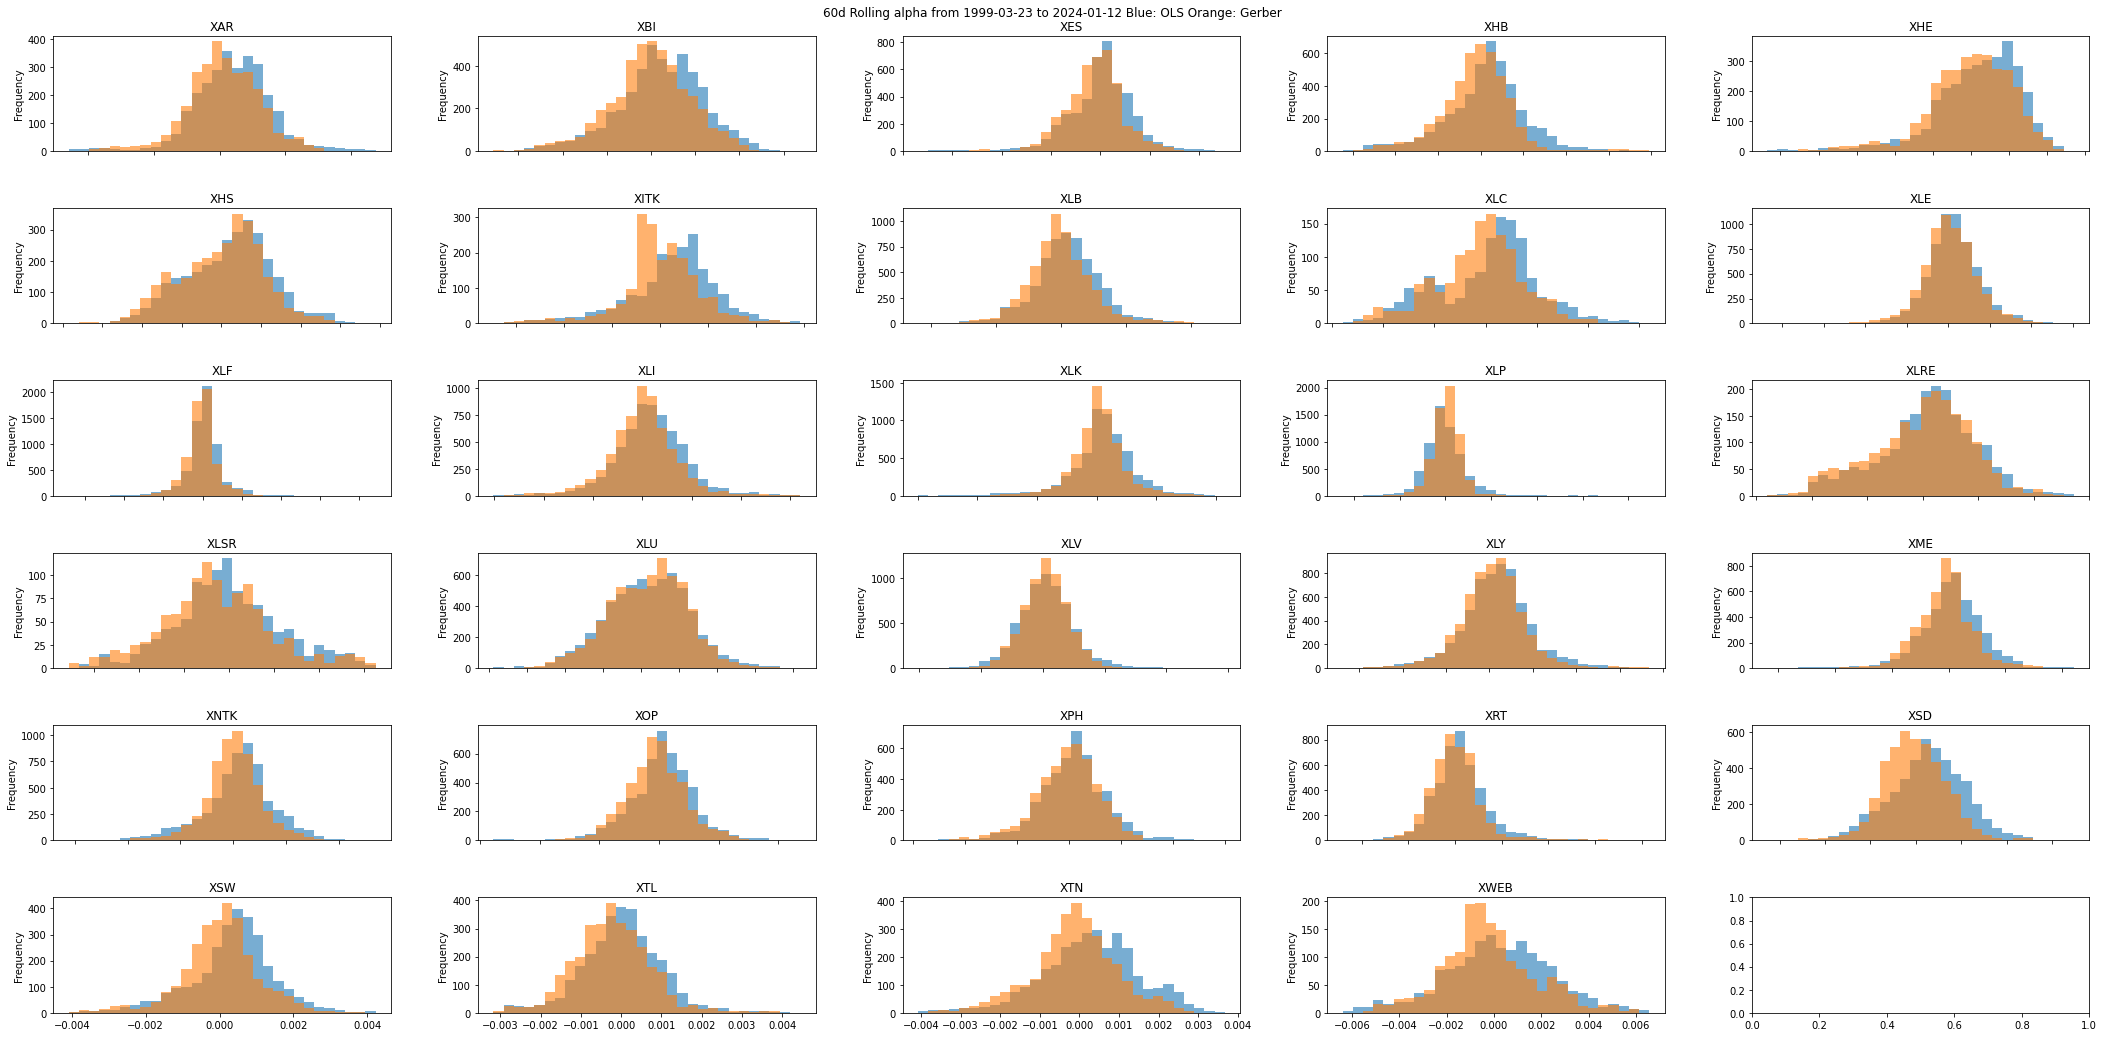

In [233]:
make_hist_graph(df_alpha, "alpha")